In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import numpy as np
import scipy
from scipy import signal as ss

from ee102b_utilities import *

## Load and Visualize Data

In [3]:
# open the data file, inspect data fields
ds = xr.open_dataset("radar_noisy_firsthalf.nc")
ds

<xarray.Dataset>
Dimensions:               (fast_time: 3200, slow_time: 2500)
Coordinates:
  * fast_time             (fast_time) float64 0.0 2e-08 ... 6.396e-05 6.398e-05
  * slow_time             (slow_time) float64 0.0 0.05128 0.1026 ... 128.1 128.2
Data variables:
    reference_chirp_real  (fast_time) float64 ...
    reference_chirp_imag  (fast_time) float64 ...
    data                  (slow_time, fast_time) int32 ...
    bed_pick              (slow_time) int64 ...
Attributes:
    fs:       50000000.0
    prf:      19.5

Unfiltered Average SNR = 26.65 dB


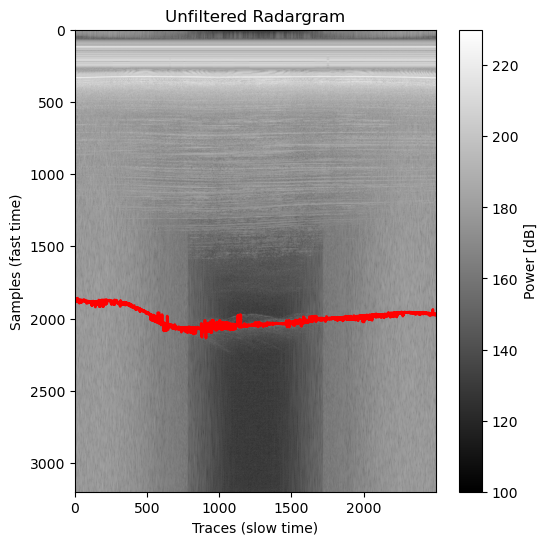

In [5]:
# view unfiltered radargram
pulse_compressed = pulse_compress(ds)
plot_radargram(pulse_compressed, title="Unfiltered Radargram", bed_x=np.arange(len(ds["slow_time"])), bed_y=ds["bed_pick"], bed=True)

snr_unfiltered, snr_avg_unfiltered = estimate_snr(pulse_compressed, ds["bed_pick"])
snr_avg_unfiltered = 10*np.log10(snr_avg_unfiltered)
print('Unfiltered Average SNR = %.2f dB' % snr_avg_unfiltered)

It's hard to see the bed reflection throughout this radargram and there's clearly some noise corrupting the data. The average SNR is okay, but SNR alone doesn't mean much if we can't see the bed. 

## Try a Simple Lowpass Filter

We know the bandwidth of the radar system is 15 MHz, so a reasonable initial guess might be that our signal will be contained entirely in the 0-15 MHz range. Let's implement a lowpass filter with a cutoff frequency of 15 MHz and apply it to the radargram to see if we can reduce some of this noise and improve the SNR and interprebility of our data.  

In [6]:
# build simple lowpass filter
lowpass_filter = scipy.signal.butter(4, 15e6, btype='lowpass', output='sos', fs=ds.fs)

# nyquist_freq = ds.fs / 2
# # cutoff_freq = [0, 8]  # Hz
# #     order = 4

# # Calculate filter coefficients
# b, a = scipy.signal.butter(4, [0.5 / nyquist_freq, 8 / nyquist_freq], btype='band')

    
data_out = np.zeros((len(ds["slow_time"]), len(ds["fast_time"]))).astype(float)
    
ref_chirp = ds["reference_chirp_real"] + 1j * ds["reference_chirp_imag"]

Lowpass Filtered Average SNR = 26.15 dB


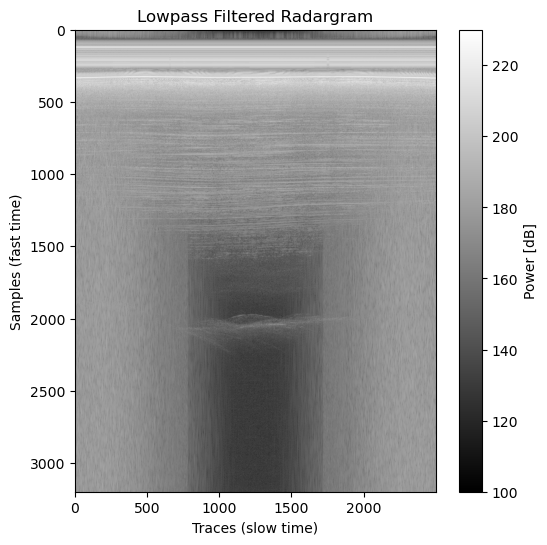

In [7]:
# apply simple lowpass filter to data
for idx, t in enumerate(ds["slow_time"]):
    trace_unfiltered = ds["data"][idx,:]
    
    trace_filtered = scipy.signal.sosfilt(lowpass_filter, trace_unfiltered)
    
    pulse_compressed = pulse_compress_one_trace(trace_filtered, ref_chirp_time_domain=ref_chirp)
    data_out[idx, :] = (20*np.log10(np.abs(pulse_compressed)))
    
plot_radargram(data_out, title="Lowpass Filtered Radargram")

snr_lowpass, snr_avg_lowpass = estimate_snr(data_out, ds["bed_pick"])
snr_avg_lowpass = 10*np.log10(snr_avg_lowpass)
print('Lowpass Filtered Average SNR = %.2f dB' % snr_avg_lowpass)

Hmmm. That didn't really do much. You'll have to get fancier and look at the noise characteristics and design filters specific to that. Happy filtering!

## Investigate Noise Characteristics, Design & Apply Filters

In [11]:
# look at noise characteristics (e.g. compute spectrogram) fill in TODOs in framework below

(1601, 2500)


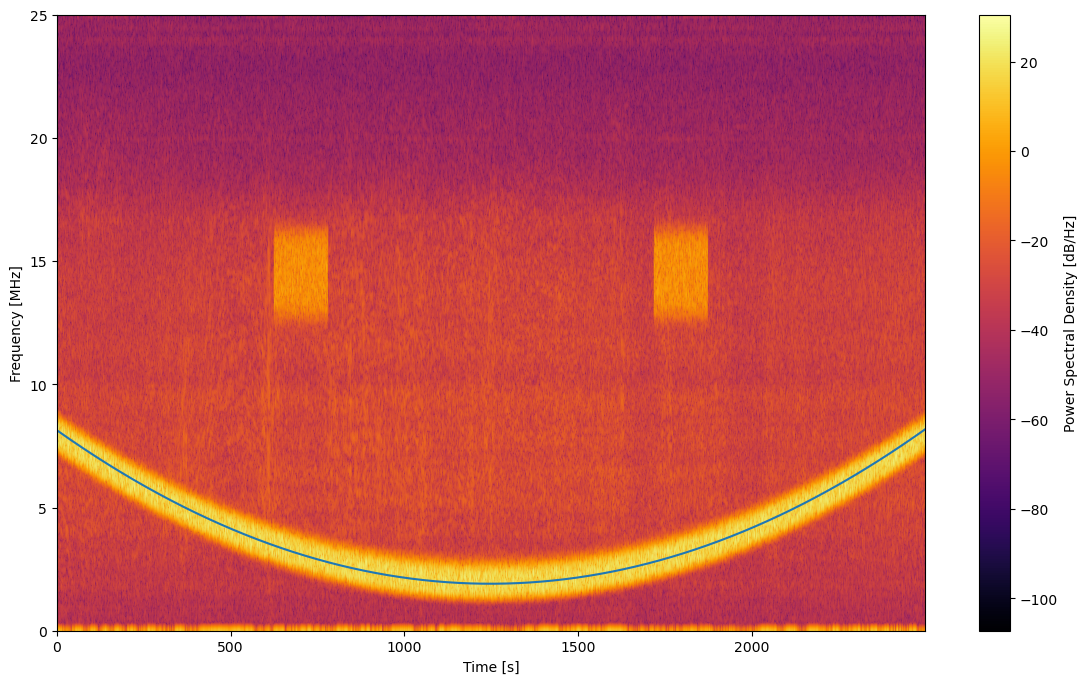

In [73]:
plot_spectrogram(signal=ds["data"].to_numpy(), window_type="chebwin", fs=ds.fs)

In [72]:

def plot_spectrogram(signal, window_type="hann", fs=None):
    nfasttime = np.shape(signal)[0]
    nslowtime = np.shape(signal)[1]
    
    #scipy.signal.gaussian(3200,90)
    #scipy.signal.kaiser(3200,150)
    #scipy.signal.chebwin(3200,4000)
    
    signal = signal.flatten()
    
    if window_type == "hann":
        window = scipy.signal.hann(3200)
    elif window_type == "hamming":
        window = scipy.signal.hamming(3200)
    elif window_type == "hamm":
        window = scipy.signal.hamm(3200)
    elif window_type == "rect":
        window = np.ones(3200)
    elif window_type == "gaussian":
        window = scipy.signal.gaussian(3200,90)
    elif window_type == "kaiser":
        window = scipy.signal.kaiser(3200,150)
    elif window_type == "chebwin":
        window = scipy.signal.chebwin(3200,4000)
    else:
        window = scipy.signal.hamming(3200)
        
    spectrogram_options = {
    "fs": fs,
    "window": window,
    "nperseg": len(ds.fast_time),
    "noverlap": 0,
    "mode": "psd",
    "scaling": "density",
    "return_onesided": True
    }
    
    f, t, Sxx_test = scipy.signal.spectrogram(signal, **spectrogram_options)
    print(np.shape(Sxx_test))
    fig, ax = plt.subplots(1,1, figsize=(14, 8), facecolor='white')
    p = plt.pcolormesh(np.arange(len(ds["slow_time"])), f/1e6, 10*np.log10(np.abs(Sxx_test)), shading='gouraud', cmap='inferno')#, vmin=-40, vmax=10)
    #p = plt.pcolormesh(t, f/1e6, 10*np.log10(np.abs(Sxx_test)), shading='gouraud', cmap='inferno')#, vmin=-40, vmax=10)
    x_pts = np.arange(2500)
    c = plt.plot(x_pts, 0.000004*np.square(x_pts-1400)+0.00122*(x_pts-1400)+2)
    clb = fig.colorbar(p, ax=ax)
    clb.set_label('Power Spectral Density [dB/Hz]')
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Frequency [MHz]')
    plt.show()
    return

In [ ]:
# apply filters that address the noise you see in the radargram (see above for example filter application if needed)
# use the visual quality of the radargram and the SNR as metrics for how well you are doing

In [14]:
# build filter
#lowpass_filter = scipy.signal.ellip(4, 1, 80, 15e6, btype='lowpass', output='sos', fs=ds.fs)
lowpass_filter = scipy.signal.butter(5, 15e6, btype='lowpass', output='sos', fs=ds.fs)

nyq = 0.5 * ds.fs
low = 2E6 / nyq
high = 8E6 / nyq
        
stopband_filter = scipy.signal.butter(5, [low, high], btype='bandstop', output='sos', fs=ds.fs)

data_out = np.zeros((len(ds["slow_time"]), len(ds["fast_time"]))).astype(float)
    
ref_chirp = ds["reference_chirp_real"] + 1j * ds["reference_chirp_imag"]

Lowpass Filtered Average SNR = 35.36 dB


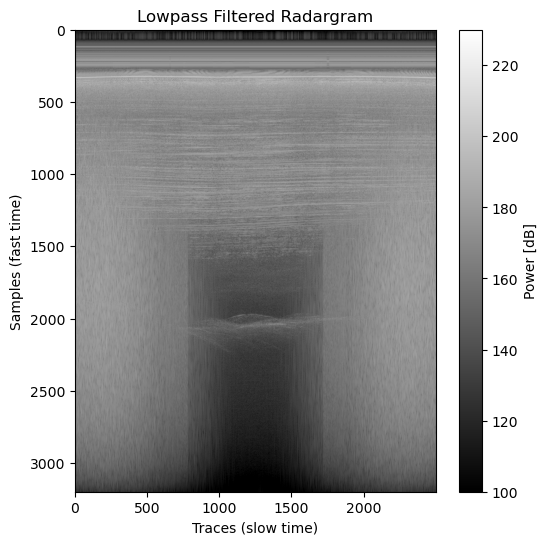

In [23]:
# apply simple lowpass filter to data
for idx, t in enumerate(ds["slow_time"]):
    trace_unfiltered = ds["data"][idx,:]
    
    #Apply a Hann Window
    hann_window = ss.hann(len(trace_unfiltered))
    windowed_signal = trace_unfiltered * hann_window
    
    trace_filtered = scipy.signal.sosfilt(stopband_filter, windowed_signal)
    
    pulse_compressed = pulse_compress_one_trace(trace_filtered, ref_chirp_time_domain=ref_chirp)
    data_out[idx, :] = (20*np.log10(np.abs(pulse_compressed)))
    
plot_radargram(data_out, title="Lowpass Filtered Radargram",  bed_x=np.arange(len(ds["slow_time"])), bed_y=ds["bed_pick"], bed=False)

snr_lowpass, snr_avg_lowpass = estimate_snr(data_out, ds["bed_pick"])
snr_avg_lowpass = 10*np.log10(snr_avg_lowpass)
print('Lowpass Filtered Average SNR = %.2f dB' % snr_avg_lowpass)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

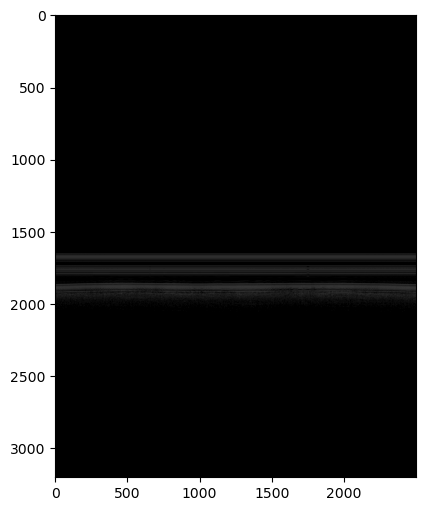

In [30]:
data_out = np.zeros((len(ds["slow_time"]), len(ds["fast_time"]))).astype(float)

# Apply matched filter to data
for idx, t in enumerate(ds["slow_time"]):
    trace_unfiltered = ds["data"][idx, :]
    
    # Normalize the reference chirp
    ref_chirp /= np.linalg.norm(ref_chirp)
    
    # Apply matched filter
    trace_filtered = signal.correlate(trace_unfiltered, ref_chirp, mode='same')
    
    pulse_compressed = pulse_compress_one_trace(trace_filtered, ref_chirp_time_domain=ref_chirp)
    data_out[idx, :] = (20 * np.log10(np.abs(pulse_compressed)))

plot_radargram(data_out, title="Matched Filtered Radargram", bed_x=np.arange(len(ds["slow_time"])), bed_y=ds["bed_pick"])

snr_matched, snr_avg_matched = estimate_snr(data_out, ds["bed_pick"])
snr_avg_matched = 10 * np.log10(snr_avg_matched)
print('Matched Filtered Average SNR = %.2f dB' % snr_avg_matched)

## Apply Adaptive Filtering -- Eliminate Trial and Error

In [13]:
import numpy as np
from scipy import signal

# Assuming you have the radargram data in the `ds["data"]` array
# and the reference chirp waveform in the `ref_chirp` array

data_out = np.zeros((len(ds["slow_time"]), len(ds["fast_time"]))).astype(float)

# Adaptive filter parameters
filter_length = len(ref_chirp)  # Length of the adaptive filter
mu = 0.01  # Step size parameter for the LMS algorithm

# Initialize adaptive filter coefficients
filter_coeffs = np.zeros(filter_length)

# Apply adaptive filtering to data
for idx, t in enumerate(ds["slow_time"]):
    trace_unfiltered = ds["data"][idx, :]
    
    # Normalize the reference chirp
    ref_chirp /= np.linalg.norm(ref_chirp)
    
    # Apply adaptive filtering using LMS algorithm
    filtered_signal, filter_state = signal.lfilter(filter_coeffs, 1, trace_unfiltered, zi=np.zeros(filter_length-1))
    filter_coeffs, _ = signal.lms(ref_chirp, filtered_signal, mu=mu)
    
    pulse_compressed = pulse_compress_one_trace(filtered_signal, ref_chirp_time_domain=ref_chirp)
    data_out[idx, :] = (20 * np.log10(np.abs(pulse_compressed)))

plot_radargram(data_out, title="Adaptive Filtered Radargram")

snr_adaptive, snr_avg_adaptive = estimate_snr(data_out, ds["bed_pick"])
snr_avg_adaptive = 10 * np.log10(snr_avg_adaptive)
print('Adaptive Filtered Average SNR = %.2f dB' % snr_avg_adaptive)


AttributeError: module 'scipy.signal' has no attribute 'lms'

3200
3200


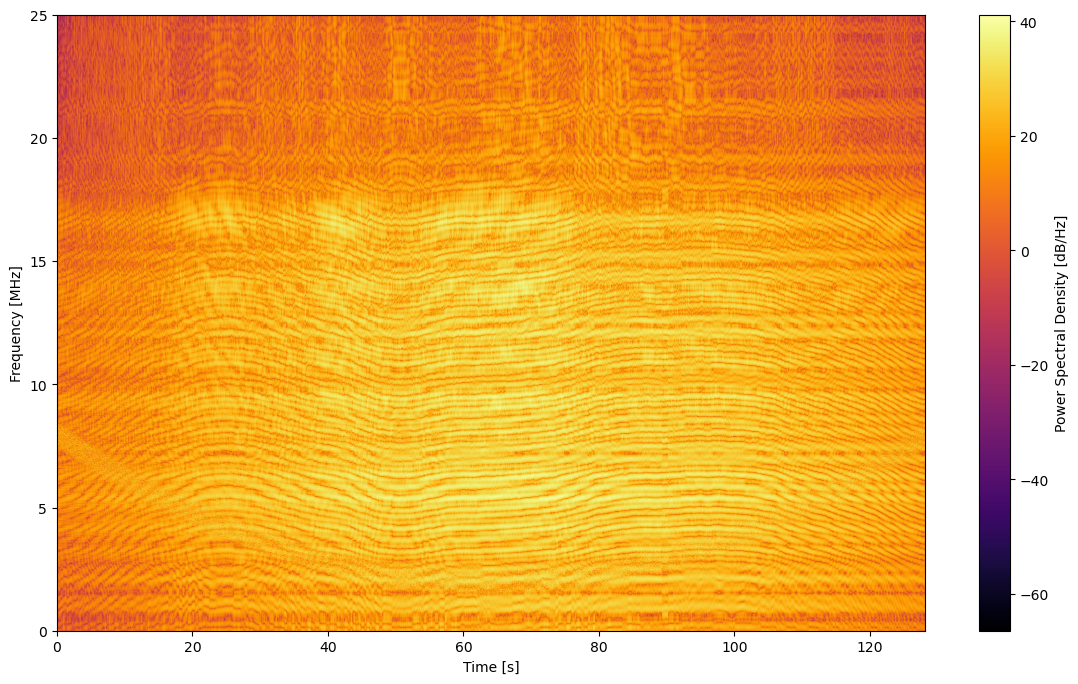

In [14]:
window = scipy.signal.hamming(3200)
#scipy.signal.gaussian(3200,90)
#scipy.signal.kaiser(3200,150)
#scipy.signal.chebwin(3200,4000)

print(len(window))
print(len(ds.fast_time))

spectrogram_options = {
    "fs": ds.fs,
    "window": window,
    "nperseg": len(ds.fast_time),
    "noverlap": 1,
    "mode": "psd",
    "scaling": "density",
    "return_onesided": True
}
f, t, Sxx_test = scipy.signal.spectrogram(ds["data"].to_numpy().flatten(), **spectrogram_options)

fig, ax = plt.subplots(1,1, figsize=(14, 8), facecolor='white')
p = plt.pcolormesh(ds["slow_time"], f/1e6, 10*np.log10(np.abs(Sxx_test)), shading='gouraud', cmap='inferno')#, vmin=-40, vmax=10)
clb = fig.colorbar(p, ax=ax)
clb.set_label('Power Spectral Density [dB/Hz]')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Frequency [MHz]')
plt.show()